### Import libraries and dataset

In [28]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy' 
dataset_array = np.load(dataset_processed_path + dataset_file)

In [29]:
dataset_array[:3]

array([[ 0.00000000e+00,  2.08772576e-06, -2.99831271e-09,
         9.99999978e-03,  0.00000000e+00,  0.00000000e+00,
         4.57880469e-06,  1.00000000e+00],
       [ 2.50000000e+01,  3.32546443e-01,  1.18597341e-03,
         9.99999978e-03,  0.00000000e+00,  0.00000000e+00,
         2.46704696e-03,  9.99996960e-01],
       [ 3.20000000e+01,  6.73775494e-01,  3.24973138e-03,
         9.99999978e-03,  0.00000000e+00,  0.00000000e+00,
         3.54966987e-03,  9.99993682e-01]])

### Create VGG16 model

In [18]:
# Load pre-trained VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='avg')

### Create VGG16 features dataset

In [2]:
# Initialize new array
data = np.empty((len(dataset_array), 1+7+512))  # VGG16 output size is 512

# Iterate over each row in the dataset
for i in range(len(dataset_array)):
    # Load image
    img_path = dataset_processed_path + str(dataset_array[i,0].astype(int)) + '.jpg'
    img = Image.open(img_path)
    img = img.resize((224, 224))  # VGG16 expects 224x224 images
    img_data = kimage.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    # Compute global descriptor
    vgg16_feature = vgg16.predict(img_data)

    # Store data
    data[i,0] = dataset_array[i,0]
    data[i,1:8] = dataset_array[i,1:8]
    data[i,8:] = vgg16_feature.squeeze()

# Save data
np.save(dataset_processed_path + 'vgg16.npy', data)

2023-11-23 15:00:50.202787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 15:00:50.203403: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 0s 81ms/step


### Plot positions of filtered dataset

[[ 0.00000000e+00  2.08772576e-06 -2.99831271e-09 ...  2.27617010e-01
   4.79837097e-02  0.00000000e+00]
 [ 2.50000000e+01  3.32546443e-01  1.18597341e-03 ...  4.46115464e-01
   4.34962809e-02  0.00000000e+00]
 [ 3.20000000e+01  6.73775494e-01  3.24973138e-03 ...  3.10521096e-01
   9.25350860e-02  4.48312126e-02]]


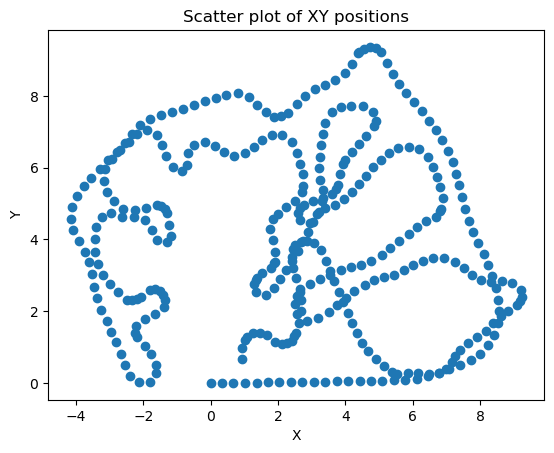

In [20]:
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
positions = vgg16_dataset[:, 1:3]
print(vgg16_dataset[:3])
# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()


# Image Retrieval

### TEST 1

1/1 [==============================] - 0s 148ms/step


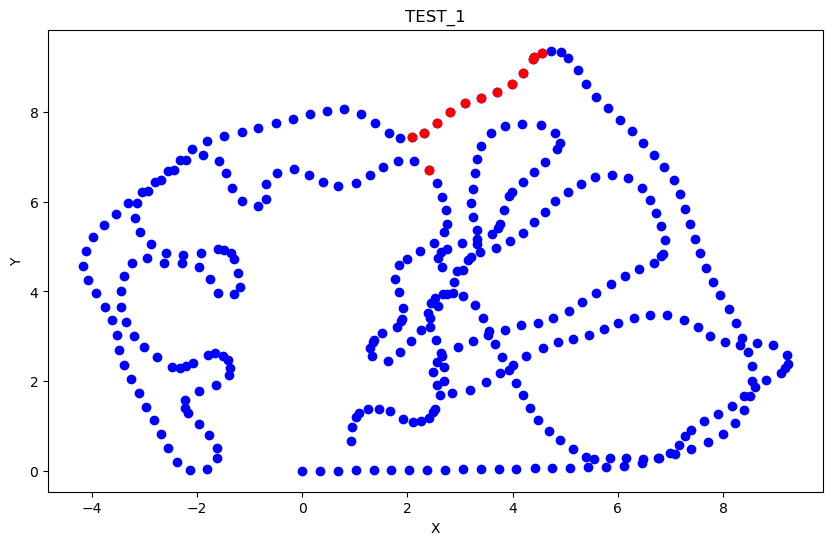

In [48]:
import os
import re

N = 10
filter = True
test = 'test_1'

# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=5).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

### TEST 2

1/1 [==============================] - 0s 103ms/step


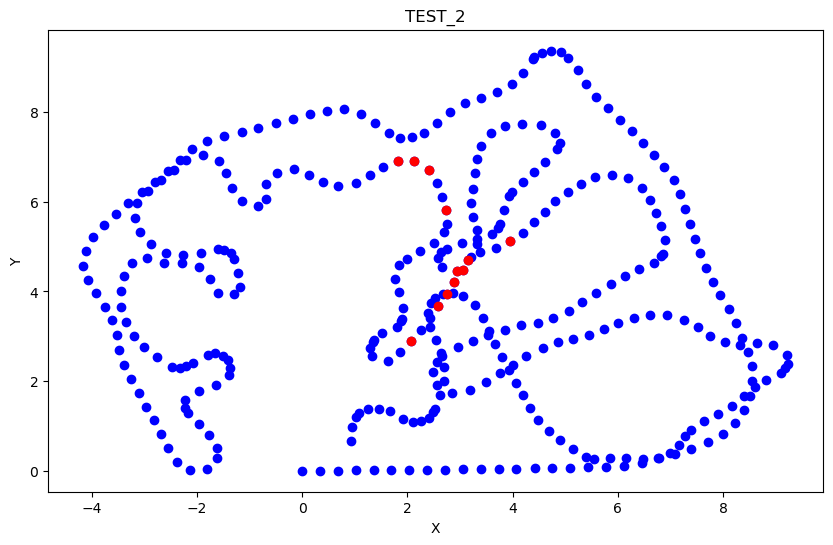

In [50]:
import os
import re

N = 10
filter = True
test = 'test_2'

# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=4).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

### TEST 3

1/1 [==============================] - 0s 82ms/step


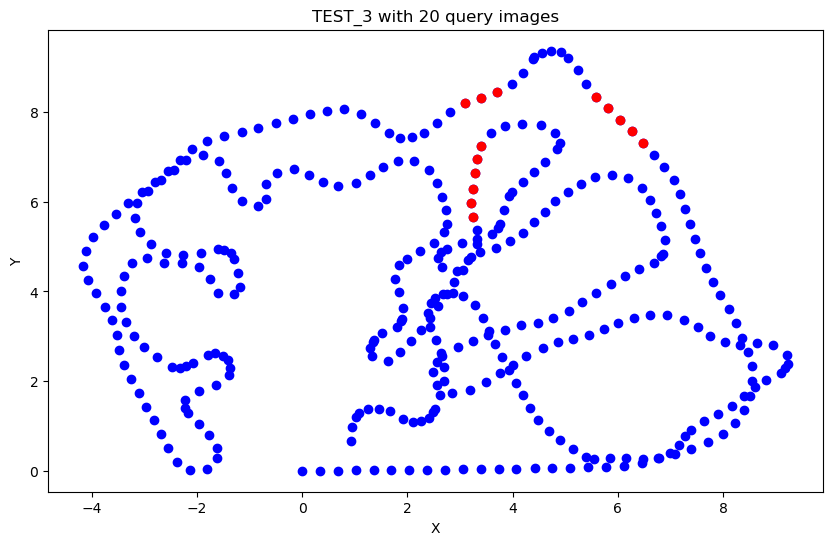

In [52]:
import os
import re

N = 5
filter = True

# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = 'test_3/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.4, min_samples=3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'TEST_3 with 20 query images')
plt.show()

### TEST 4 

1/1 [==============================] - 0s 88ms/step


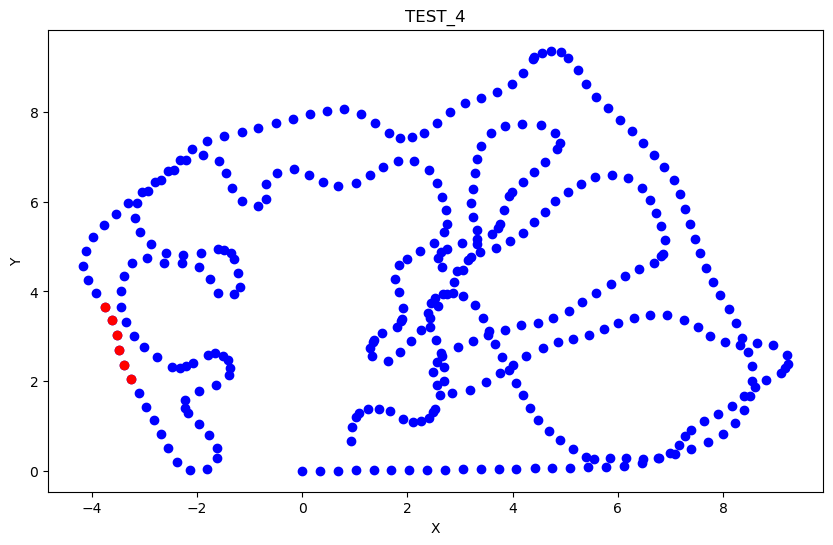

In [53]:
import os
import re

N = 5
filter = True
test = 'test_4'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=5).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'TEST_4')
plt.show()

### TEST 5

1/1 [==============================] - 0s 107ms/step


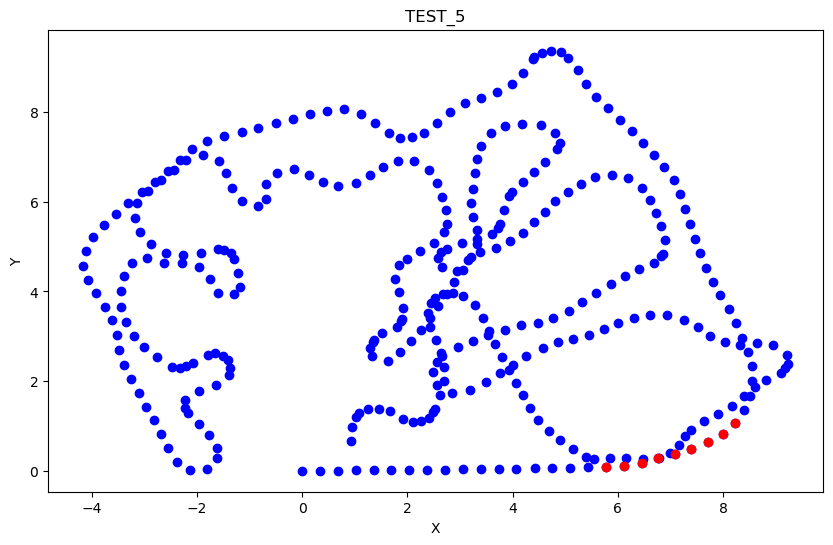

In [54]:
import os
import re

N = 5
filter = True

# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = 'test_5/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=5).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'TEST_5')
plt.show()

### TEST 6

1/1 [==============================] - 0s 117ms/step


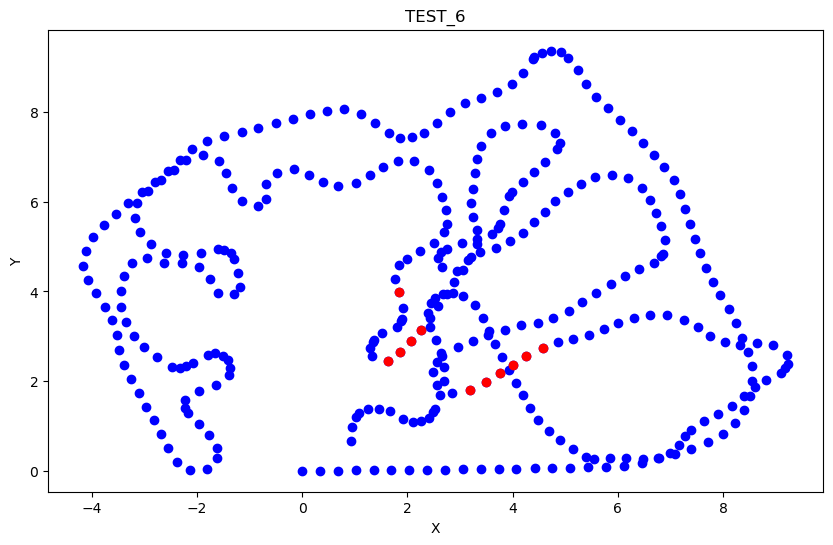

In [55]:
import os
import re

N = 5
filter = True
test = 'test_6'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=5).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

# DATASET v2

In [30]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
dataset_file = 'filtered_dataset_v2.npy' 
dataset_array = np.load(dataset_processed_path + dataset_file)

In [31]:
dataset_array[:3]

array([[ 0.00000000e+00,  1.26900955e-06, -1.88639280e-07,
         1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
        -7.23014980e-02,  9.97382822e-01],
       [ 5.40000000e+01,  2.95406354e-01, -4.50266366e-02,
         1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
        -7.90274330e-02,  9.96872442e-01],
       [ 6.30000000e+01,  6.03775132e-01, -1.02215713e-01,
         1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
        -1.16254863e-01,  9.93219415e-01]])

In [32]:
# Load pre-trained VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='avg')

### Create VGG16 database v2

In [33]:
# Initialize new array
data = np.empty((len(dataset_array), 1+7+512))  # VGG16 output size is 512

# Iterate over each row in the dataset
for i in range(len(dataset_array)):
    # Load image
    img_name = f'image_{dataset_array[i,0].astype(int)}.jpg'
    img_path = os.path.join(dataset_processed_path, img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))  # VGG16 expects 224x224 images
    img_data = kimage.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    # Compute global descriptor
    vgg16_feature = vgg16.predict(img_data)

    # Store data
    data[i,0] = dataset_array[i,0]
    data[i,1:8] = dataset_array[i,1:8]
    data[i,8:] = vgg16_feature.squeeze()

# Save data
np.save(dataset_processed_path + 'vgg16.npy', data)

1/1 [==============================] - 0s 14ms/step


[[ 0.00000000e+00  1.26900955e-06 -1.88639280e-07 ...  0.00000000e+00
   5.07884145e-01  1.10747278e-01]
 [ 5.40000000e+01  2.95406354e-01 -4.50266366e-02 ...  9.16531533e-02
   4.07502770e-01  0.00000000e+00]
 [ 6.30000000e+01  6.03775132e-01 -1.02215713e-01 ...  0.00000000e+00
   1.07457471e+00  0.00000000e+00]]


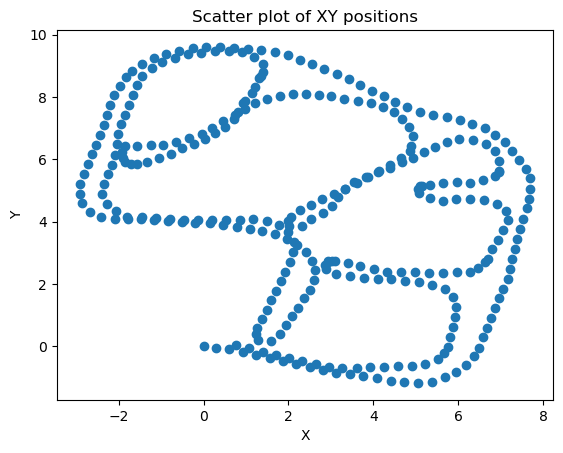

In [34]:
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
positions = vgg16_dataset[:, 1:3]
print(vgg16_dataset[:3])
# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()

# Image Retrieval

### TEST 1

1/1 [==============================] - 0s 15ms/step


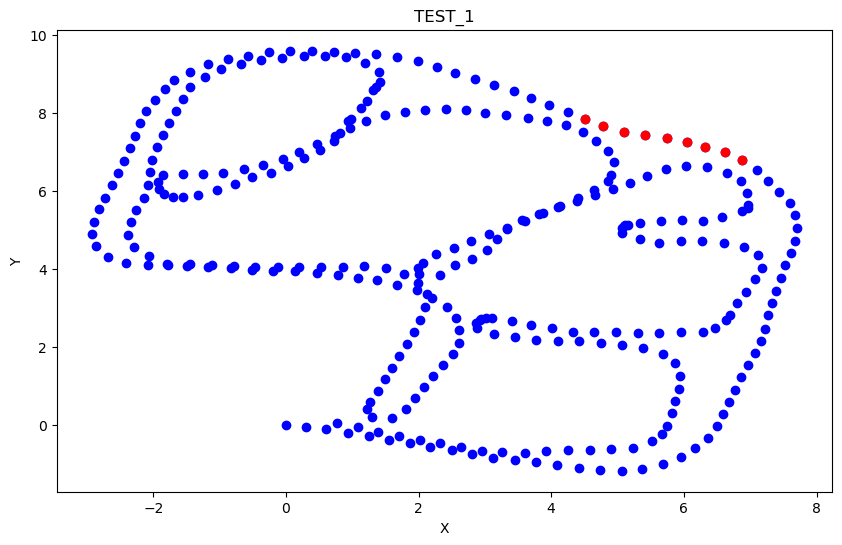

In [41]:
import os
import re

N = 5
filter = True
test = 'test_1'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

### TEST 2

1/1 [==============================] - 0s 17ms/step


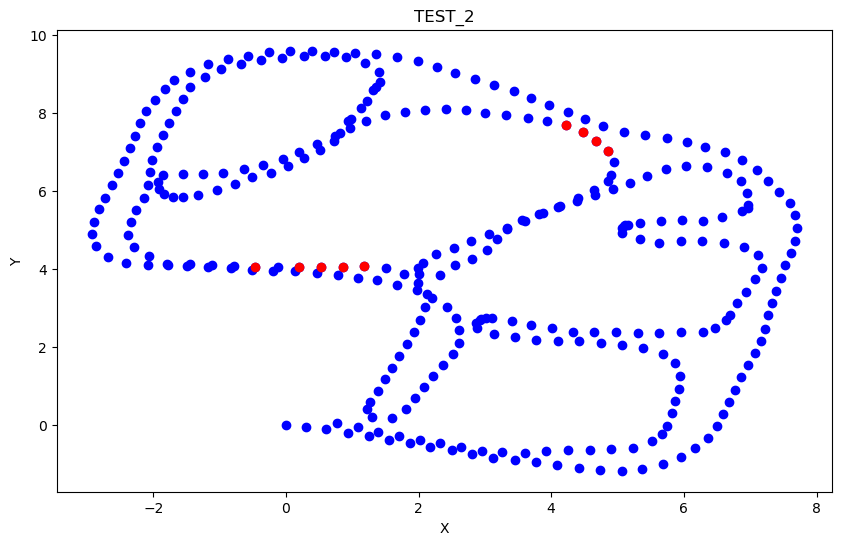

In [36]:
import os
import re

N = 5
filter = True
test = 'test_2'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

### TEST 3

1/1 [==============================] - 0s 16ms/step


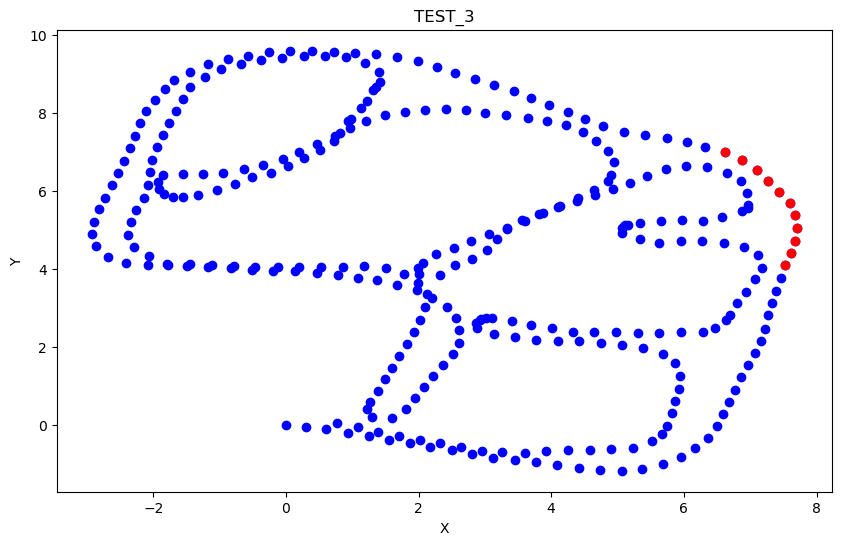

In [37]:
import os
import re

N = 5
filter = True
test = 'test_3'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

### TEST 4

1/1 [==============================] - 0s 16ms/step


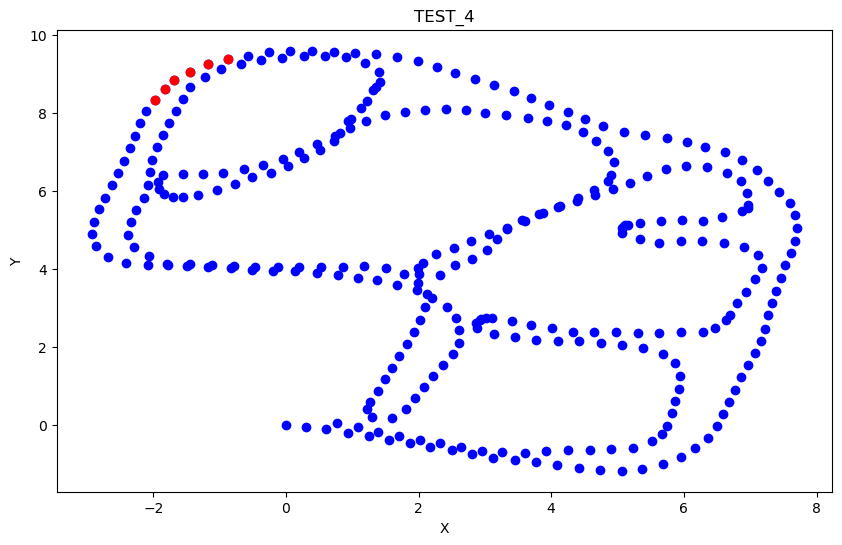

In [38]:
import os
import re

N = 5
filter = True
test = 'test_4'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

### TEST 5

1/1 [==============================] - 0s 15ms/step


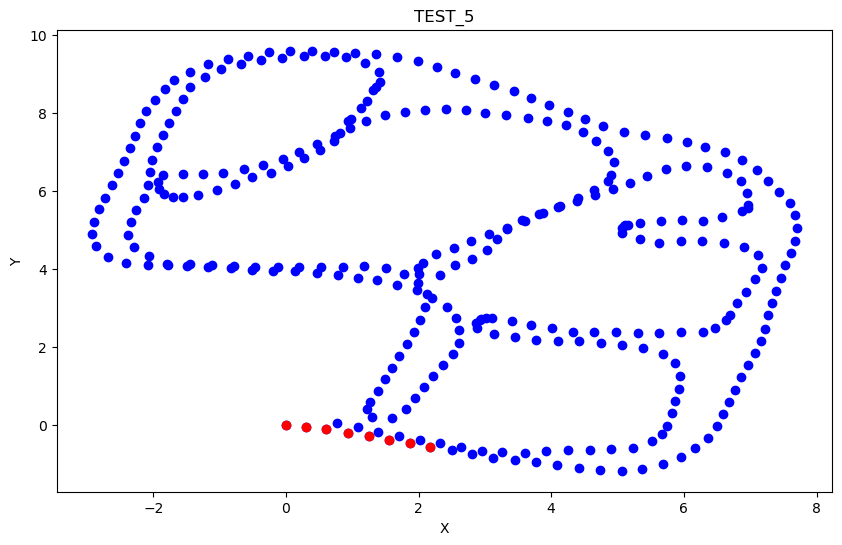

In [39]:
import os
import re

N = 5
filter = True
test = 'test_5'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()

### TEST 6

1/1 [==============================] - 0s 16ms/step


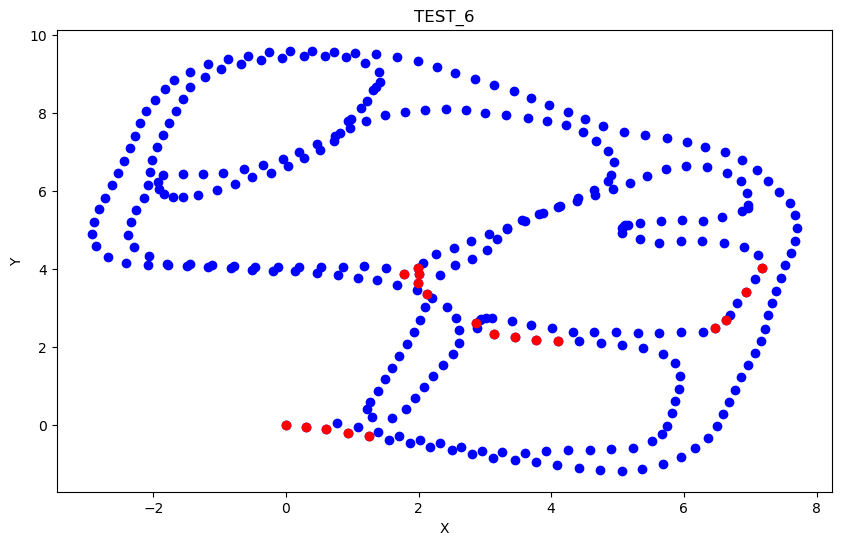

In [40]:
import os
import re

N = 5
filter = True
test = 'test_6'
# Sort images by name
def extract_number(image_file):
    match = re.search(r'\d+', image_file)
    return int(match.group()) if match else float('inf')

image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/'
test_path = f'{test}/'
image_files = os.listdir(image_reloc_path + test_path)
image_files.sort(key=extract_number)

all_top_positions = np.empty((0, 2))

for image_file in image_files:
    # Open image
    image_reloc = Image.open(image_reloc_path + test_path + image_file)
    
    # Calculate VGG16 global descriptor for query image
    image_reloc = image_reloc.resize((224, 224))
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean similarities
    similarities = np.array([np.linalg.norm(vgg16_feature - vgg16) for vgg16 in vgg16_dataset[:, 8:]])
    
    # Top N similar images
    sorted_indices = similarities.argsort()
    top_N_indices = sorted_indices[:N]
    top_N_images = vgg16_dataset[top_N_indices]
    
    # Extract XY positions of top 10 images
    top_N_positions = top_N_images[:, 1:3]
    
    # Add top N positions to all top positions
    all_top_positions = np.concatenate((all_top_positions, top_N_positions))
    
all_top_positions = np.unique(all_top_positions, axis=0)
filtered_top_positions = all_top_positions

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=1, min_samples=3).fit(all_top_positions)
    filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 0], filtered_top_positions[:, 1], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'{test.upper()}')
plt.show()